# Modelagem - Quality Prediction in a Mining Process

* Ciencia de Dados - IHM Stefanini
* Autor: Alisson Santiago Amaral, Cientista de dados.

> Objetivo:

* O objetivo principal é analisar e modelar os dados de medições de qualidade no processo de flotação do minério de ferro, para prever a quantidade de sílica (impureza) no concentrado de minério.

> Motivação:
* Como essa impureza é medida a cada hora, se pudermos prever quanta sílica (impureza) há no concentrado de minério, podemos ajudar os engenheiros, dando-lhes informações para que tomem decisões antecipadas. Assim, eles poderão antecipar ações corretivas (diminuir impurezas, se for o caso) e também ajudar o meio ambiente (diminuindo a quantidade de minério que vai para o rejeito à medida que você reduz a sílica no concentrado de minério).

* Ao final do projeto poderemos responder alguns questionamentos:
    - É possível prever a % de sílica concentrada a cada minuto?
    - Quantas etapas (horas) à frente podemos prever % de sílica concentrada?
    - É possível prever % de sílica em concentrado sem a coluna de concentrado de ferro (como eles estão altamente correlacionados)?

> Fonte:

* https://www.kaggle.com/datasets/edumagalhaes/quality-prediction-in-a-mining-process

> Importante:
* Nesta seção iremos testar algumas abordagem de séries temporais, e visando objetividade iremos utilizar o Data_1 com todas as features.

## Sumário:

0. Introdução

        0.1 Imports
                0.1.1 Bibliotecas
                0.1.2 Dataset imports
        0.2 Garantindo a integridade dos dados


1. Escolha do modelo

        1.1 ARIMA
                1.1.1 Divisão do dataset
                1.1.2 Scale
                1.1.3 Treino e predições

        1.2 LSTM
                1.2.1 Divisão do dataset
                1.2.2 Scale
                1.2.3 Treino e predições

2. Resultado final
        2.1 Conclusão

3. Referências

# 0. Introdução

## 0.1 Imports

### 0.1.1 Bibliotecas


In [1]:
#Importando as bibliotecas
import pandas as pd
import numpy as np
from scipy import stats

#Data Viz
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Feature scale and split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Models
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential

    # ARIMA
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Métrics
from sklearn import metrics
import missingno as msno


import warnings
warnings.filterwarnings('ignore')

import random

#import torch
#print(torch.cuda.is_available())

random.seed(9)

### 0.1.3 Dataset imports

In [2]:
df = pd.read_csv('./Dataset/df_hour.csv', decimal=".",sep=",", 
                    parse_dates=["date"], infer_datetime_format=True)
df = df.set_index('date')
df.head(3)

,per_iron_feed,per_silica_feed,starch_flow,amina_flow,ore_pulp_flow,ore_pulp_ph,ore_pulp_density,column_01_air_flow,column_02_air_flow,column_03_air_flow,...,column_06_level,column_07_level,per_iron_concentrate,per_silica_concentrate,column_06_07_level,column_01_02_03_level,column_04_05_level,column_01_02_03_air_flow,column_04_05_air_flow,column_06_07_air_flow
date,,,,,,,,,,,,,,,,,,,,,
2017-03-29 19:00:00,59.54,9.56,1913.01,495.24,399.95,9.56,1.67,199.87,195.57,200.05,...,518.05,523.23,66.28,1.69,520.640,852.443333,558.215,198.496667,300.75,250.025
2017-03-29 20:00:00,59.54,9.56,2033.82,500.49,400.51,9.28,1.68,199.90,195.38,199.86,...,549.20,548.97,64.13,1.81,549.085,851.743333,595.615,198.380000,300.75,250.045
2017-03-29 21:00:00,59.54,9.56,2213.60,530.64,400.36,9.59,1.72,199.88,195.37,199.92,...,549.18,552.95,65.88,1.71,551.065,851.496667,596.145,198.390000,300.75,250.115


## 0.2 Garantindo a integridade dos dados

* Primeiramente vamos avaliar a integridade da série temporal, procurando por gaps dentro da série.

<AxesSubplot:>

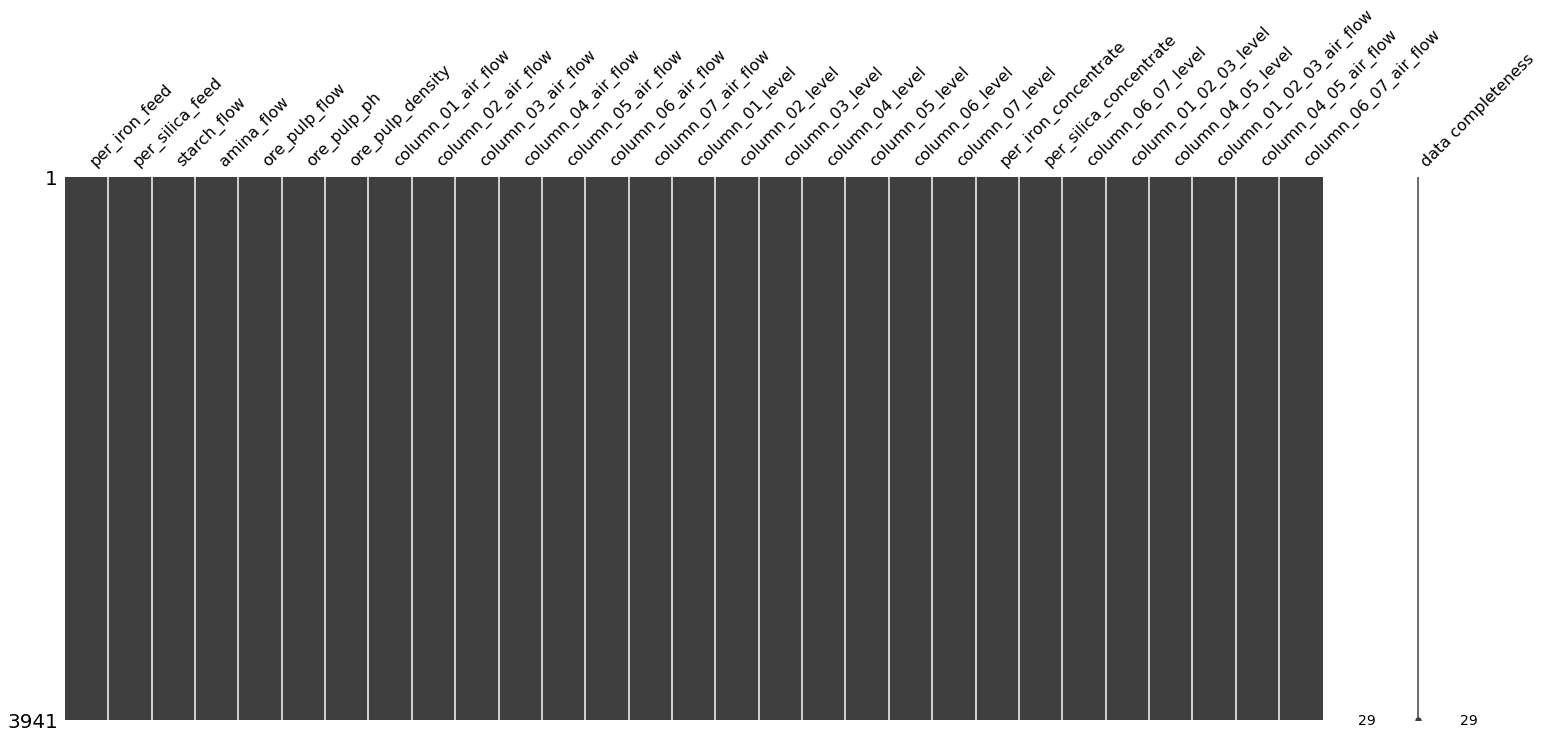

In [3]:
msno.matrix(df, labels=True, sort="descending")

> Observação:

Os dados estão integros

> Vamos avaliar a quantidade de valores únicos de cada variável

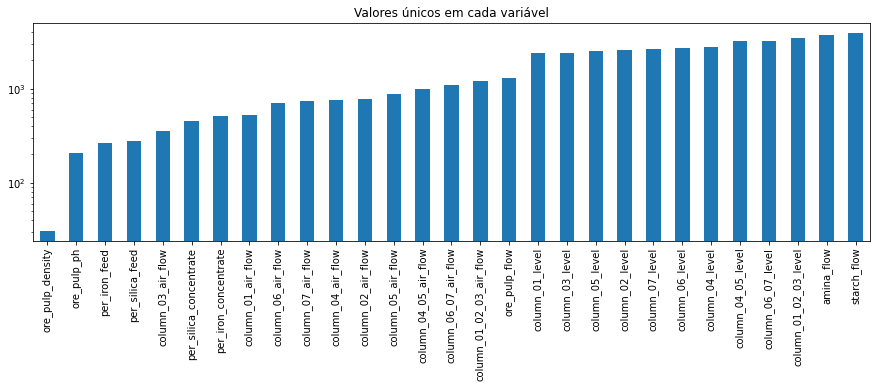

In [4]:
# For each numerical feature compute number of unique entries
unique_values = df.nunique().sort_values()

# Plot information with y-axis in log-scale
unique_values.plot.bar(logy=True, figsize=(15, 4), title="Valores únicos em cada variável");

In [5]:
n_duplicates = df.duplicated().sum()
print(f"Nós temos {n_duplicates} valores duplicados no database.")

Nós temos 0 valores duplicados no database.


* lags

> Observação: 

        * Iremos utilizar as funções de autocorrelação (ACF) e autocorrelação parcial (PACF) para identificar e escolher os lags.

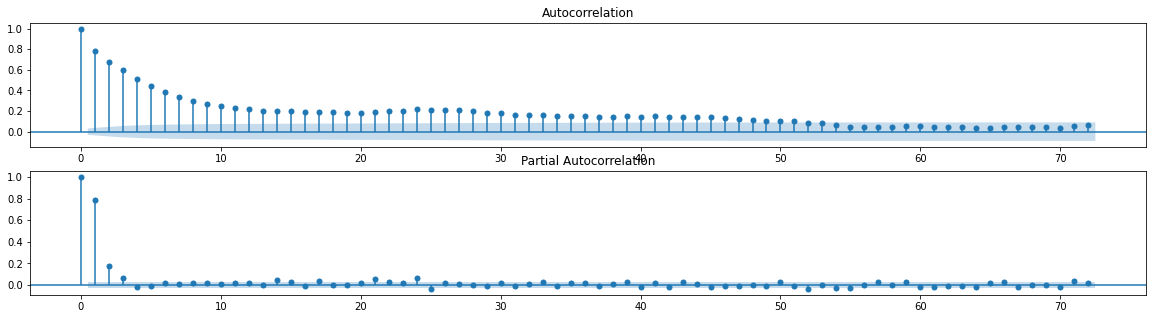

In [6]:
fig,ax= plt.subplots(2,1, figsize=(20,5))
fig=sm.tsa.graphics.plot_acf(df['per_silica_concentrate'], lags=72, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(df['per_silica_concentrate'], lags=72, ax=ax[1])
plt.show()

> Observações:

        * Os gráficos de ACF e PACF nos mostram que os lags de 1 a 4 tem magnitude maior, sendo que o lag 1 e 2 são os com maiores impactos.

        * Além disso é possível identificar uma pequena(tímida) sazonalidade nos primeiros lags +24. Indicando que há um leve impacto nos passos -24 de cada medição. Não acho interessante nesse primeiro momento utilizar essa sazonalidade.

> Próximos passos:

        * Iremos produzir 3 variáveis com atrasos no target.

In [7]:
df['per_silica_-1h'] = df['per_silica_concentrate'].shift(1)
df['per_silica_-2h'] = df['per_silica_concentrate'].shift(2)
df['per_silica_-3h'] = df['per_silica_concentrate'].shift(3)

df = df.iloc[3:]

* Vazão massica

In [8]:
#df['vazao_massica'] = df['ore_pulp_flow'] * (df['ore_pulp_density'])

* Trabalhando com a hora e dia da semana: Sabendo que são variáveis cíclicas que podem afetar o desempenho do modelo de série temporal, iremos testar se essas variáveis irão melhorar os resultados. Para isso iremos transformar as variáveis cíclicas no seno e cosseno das mesmas. Dessa forma conseguimos mostrar para o modelo que a hora e o dia na semana são ciclos que se repetem.

In [9]:
df['hora'] = df.index.hour
df['dia'] = df.index.weekday

In [10]:
df["sin_hora"] = (np.sin((2*np.pi*(df["hora"])/24))) + 1
df["cos_hora"] = (np.cos((2*np.pi*(df["hora"])/24))) + 1

df["sin_dia"] = (np.sin((2*np.pi*(df["dia"])/31))) + 1
df["cos_dia"] = (np.cos((2*np.pi*(df["dia"])/31))) + 1

# Deletando hora e dia
del df["hora"]
del df["dia"]


In [11]:
df.head()

,per_iron_feed,per_silica_feed,starch_flow,amina_flow,ore_pulp_flow,ore_pulp_ph,ore_pulp_density,column_01_air_flow,column_02_air_flow,column_03_air_flow,...,column_01_02_03_air_flow,column_04_05_air_flow,column_06_07_air_flow,per_silica_-1h,per_silica_-2h,per_silica_-3h,sin_hora,cos_hora,sin_dia,cos_dia
date,,,,,,,,,,,,,,,,,,,,,
2017-03-29 22:00:00,59.54,9.56,2004.49,531.89,399.08,9.64,1.73,199.89,196.65,199.91,...,198.816667,300.75,249.96,1.71,1.81,1.69,0.500000,1.866025,1.394356,1.918958
2017-03-29 23:00:00,59.54,9.56,1813.14,530.98,400.06,9.59,1.72,199.90,195.33,199.97,...,198.400000,300.75,250.04,2.92,1.71,1.81,0.741181,1.965926,1.394356,1.918958
2017-03-30 00:00:00,59.54,9.56,1975.23,537.12,399.89,9.62,1.73,199.93,195.54,199.82,...,198.430000,300.75,250.10,2.00,2.92,1.71,1.000000,2.000000,1.571268,1.820763
2017-03-30 01:00:00,60.44,9.19,2046.82,489.64,401.36,9.70,1.68,199.82,195.46,199.81,...,198.363333,300.75,249.62,1.69,2.00,2.92,1.258819,1.965926,1.571268,1.820763
2017-03-30 02:00:00,60.44,9.19,1907.99,335.45,410.85,9.41,1.54,199.75,195.34,199.98,...,198.356667,300.75,249.97,3.80,1.69,2.00,1.500000,1.866025,1.571268,1.820763


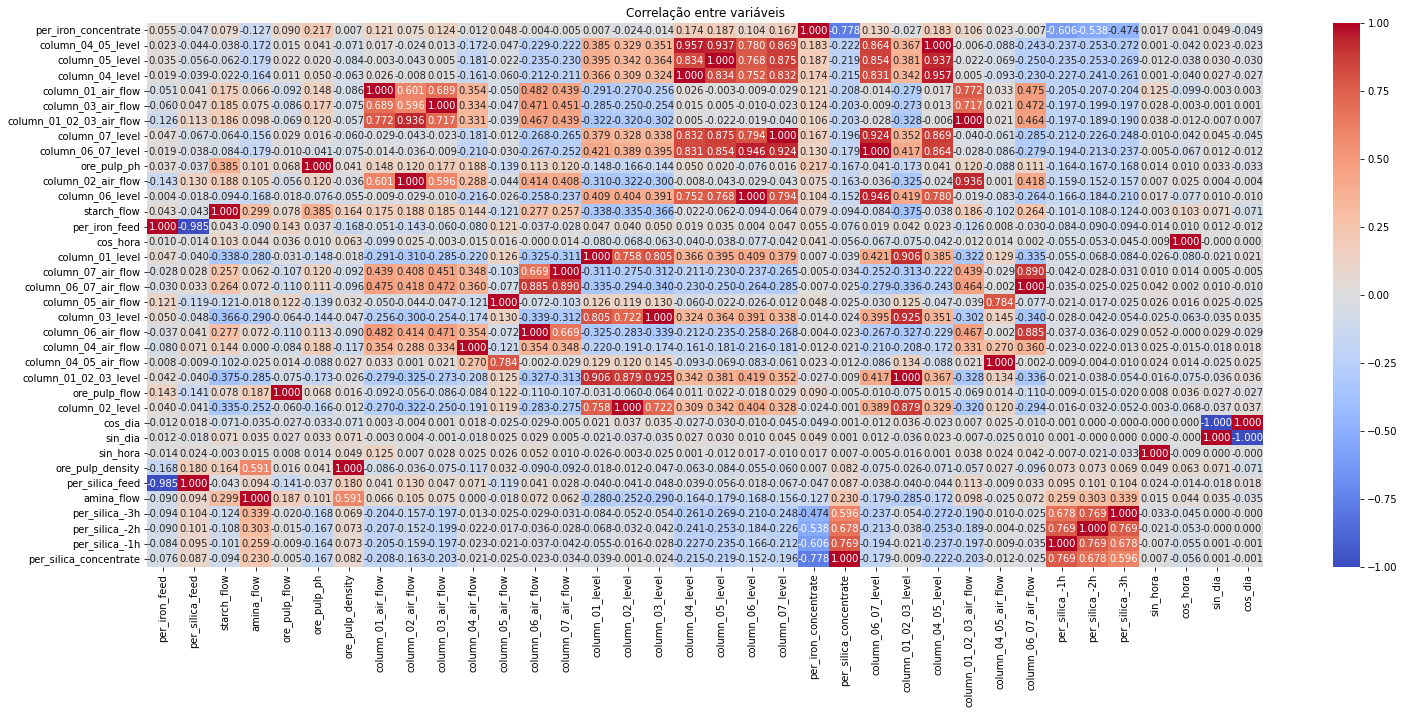

In [12]:
plt.figure(figsize=(25, 10))

sns.heatmap(df.corr(method='spearman').sort_values('per_silica_concentrate'),
            annot = True,
            fmt = '.3f',
            cmap='coolwarm')
plt.title('Correlação entre variáveis')
plt.show()

# 1. Escolha do modelo

## 1.1 ARIMA

### 1.1.1 Divisão do dataset(Treino e Teste)

In [16]:
#X = df.drop([ 'column_02_air_flow', 'column_05_air_flow', 'column_07_air_flow', 'column_02_level'
                    #, 'column_05_level', 'column_07_level', 'per_silica_concentrate','per_iron_concentrate'], axis=1)
#Y = df['per_silica_concentrate']

In [211]:
Data_2 = df.iloc[:-120].loc[:,['per_silica_feed' ,'starch_flow', 'amina_flow', 'ore_pulp_flow', 'ore_pulp_density',
            'column_01_air_flow', 'column_03_air_flow', 'column_04_air_flow', 'column_06_air_flow','column_01_level', 'column_03_level', 'column_04_level', 'column_06_level',
            'per_silica_-1h', 'per_silica_-2h', 'per_silica_-3h', 'per_silica_concentrate']]
Valid_2 = Data_2.iloc[-120:,:]

In [212]:
X = Data_2.drop('per_silica_concentrate', axis=1)
Y = Data_2['per_silica_concentrate']

In [213]:
def divisao_treino_teste(X, Y, test_split=0.2):

    divisao = int(len(X) * (1-test_split))
    
    train_X = X[:divisao]
    train_Y = Y[:divisao]
    test_X = X[divisao:]
    test_Y = Y[divisao:]
    return train_X, test_X, train_Y, test_Y

In [214]:
X_treino, X_teste, Y_treino, Y_teste = divisao_treino_teste(X,Y,test_split=0.15)

print('X_treino: ', X_treino.shape)
print('X_teste: ', X_teste.shape)
print('Y_treino: ', Y_treino.shape)
print('Y_teste: ', Y_teste.shape)

X_treino:  (3245, 16)
X_teste:  (573, 16)
Y_treino:  (3245,)
Y_teste:  (573,)


### 1.1.2 Scale

In [215]:
#sc_in = MinMaxScaler(feature_range=(0, 1))

sc_in = StandardScaler()
scaled_input = sc_in.fit_transform(X_treino)

scaled_input = pd.DataFrame(scaled_input, columns=X_treino.columns, index= X_treino.index)

X_treino = scaled_input

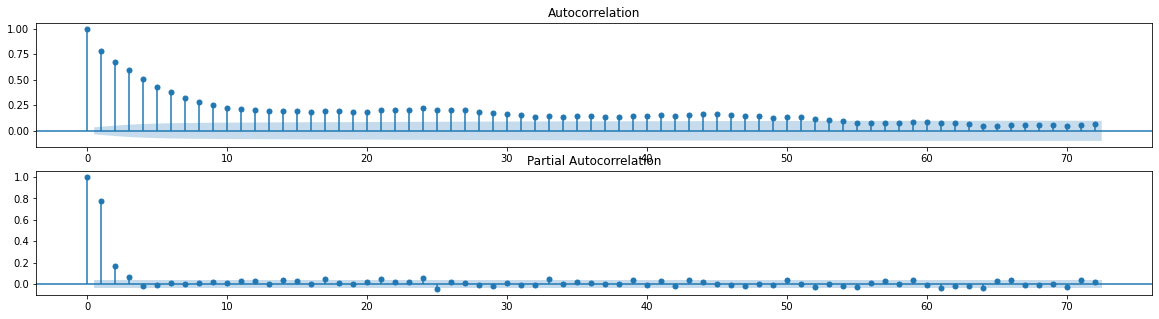

In [216]:
fig,ax= plt.subplots(2,1, figsize=(20,5))
fig=sm.tsa.graphics.plot_acf(Y_treino, lags=72, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(Y_treino, lags=72, ax=ax[1])
plt.show()

> Observações:

* Vamos definir os parâmetros do ARIMA:

    - AR (Autoregressive): o parâmetro p indica a ordem da parte autoregressiva do modelo. Isso significa que o valor atual da série temporal é modelado como uma combinação linear dos valores anteriores da série. Quanto maior o valor de p, mais valores anteriores são usados no modelo.

    - I (Integrated): o parâmetro d indica o número de vezes que a série temporal foi diferenciada para torná-la estacionária. Se a série não for estacionária (ou seja, se tiver uma média ou variância que muda com o tempo), ela pode ser diferenciada para remover as tendências ou sazonalidades. O valor de d representa o número de diferenciações necessárias para tornar a série estacionária.

    - MA (Moving Average): o parâmetro q indica a ordem da parte de média móvel do modelo. Isso significa que o valor atual da série temporal é modelado como uma combinação linear dos erros de previsão anteriores. Quanto maior o valor de q, mais erros de previsão anteriores são usados no modelo.




* Baseado nas informações anteriores iremos ajutar nesse primeiro momento um conjuto ARIMA (3,1,3)

> Update:

* Com base nos resultados do modelo o conjunto Arima foi ajusta para (2,1,2).

### 1.1.3 Treino e predições

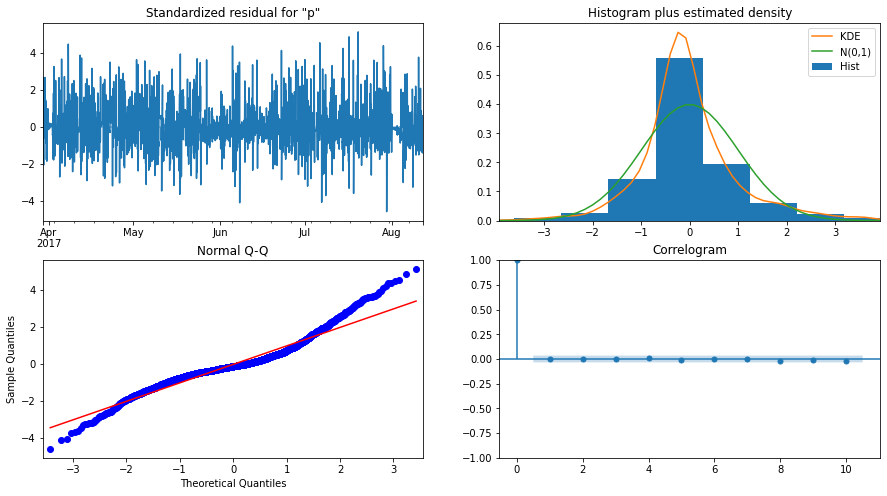

In [217]:

model= SARIMAX(Y_treino,
 exog=X_treino,
 order=(2,1,2),
 seasonal_order = (0,0,0,0), enforce_stationarity=True)

#enforce_invertibility=False, enforce_stationarity=False

results = model.fit()
results.plot_diagnostics(figsize=(15,8))
plt.show()

In [218]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:     per_silica_concentrate   No. Observations:                 3245
Model:                   SARIMAX(2, 1, 2)   Log Likelihood               -3363.067
Date:                    Fri, 31 Mar 2023   AIC                           6768.134
Time:                            12:10:06   BIC                           6895.910
Sample:                        03-29-2017   HQIC                          6813.912
                             - 08-12-2017                                         
Covariance Type:                      opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
per_silica_feed        0.0136      0.015      0.887      0.375      -0.016       0.044
starch_flow            0.0023      0.011      0.208      0.835      -0.019       0.024
amina_flow             0.0012      0.019      0.061      0.952      -0.036       0.039
ore_pulp_flow         -0.0054      0.014     -0.388      0.698      -0.033       0.022
ore_pulp_density       0.0107      0.016      0.657      0.511      -0.021       0.043
column_01_air_flow    -0.1267      0.045     -2.796      0.005      -0.215      -0.038
column_03_air_flow     0.0209      0.047      0.444      0.657      -0.071       0.113
column_04_air_flow     0.0725      0.024      2.992      0.003       0.025       0.120
column_06_air_flow     0.0278      0.026      1.072      0.284      -0.023       0.079
column_01_level        0.0047      0.016      0.292      0.770      -0.027       0.036
column_03_level       -0.0228      0.017     -1.380      0.168      -0.055       0.010
column_04_level        0.0075      0.018      0.413      0.679      -0.028       0.043
column_06_level        0.0103      0.021      0.488      0.625      -0.031       0.051
per_silica_-1h         0.1202      0.073      1.635      0.102      -0.024       0.264
per_silica_-2h         0.9210      0.029     31.699      0.000       0.864       0.978
per_silica_-3h        -0.2233      0.066     -3.366      0.001      -0.353      -0.093
ar.L1                 -0.4577      0.066     -6.971      0.000      -0.586      -0.329
ar.L2                 -0.1603      0.039     -4.064      0.000      -0.238      -0.083
ma.L1                 -0.0304      0.023     -1.341      0.180      -0.075       0.014
ma.L2                 -0.9637      0.023    -42.558      0.000      -1.008      -0.919
sigma2                 0.4645      0.009     50.338      0.000       0.446       0.483
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1467.86
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             0.69
Prob(H) (two-sided):                  0.36   Kurtosis:                         5.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [219]:
scaled_input_real = sc_in.transform(X_teste)
scaled_input_real = pd.DataFrame(scaled_input_real, columns=X_teste.columns, index= X_teste.index)

X_real = scaled_input_real

In [220]:
predicted = results.predict('2017-08-12 03:00:00', '2017-09-04 23:00:00' , exog=X_real)
predicted

2017-08-12 03:00:00    1.467852
2017-08-12 04:00:00    1.618496
2017-08-12 05:00:00    1.364310
2017-08-12 06:00:00    1.408359
2017-08-12 07:00:00    1.559727
                         ...   
2017-09-04 19:00:00    2.025494
2017-09-04 20:00:00    2.501256
2017-09-04 21:00:00    2.487565
2017-09-04 22:00:00    4.503962
2017-09-04 23:00:00    3.461265
Freq: H, Name: predicted_mean, Length: 573, dtype: float64

In [223]:
y_pred_real = pd.DataFrame(predicted)
y_pred_real.index = pd.DatetimeIndex(predicted.index)
y_pred_real = y_pred_real.round(2)



Previsao_final = pd.merge(pd.DataFrame(Y_teste), y_pred_real,left_index=True,right_index=True, how='outer')


# Create figure
fig_model = go.Figure()

# Add traces
fig_model.add_trace(
    go.Scatter(x=pd.DataFrame(predicted).index, y=pd.DataFrame(predicted)['predicted_mean'], name="Forecast", mode='lines')
)

fig_model.add_trace(
    go.Scatter(x=pd.DataFrame(Y_teste).index, y=pd.DataFrame(Y_teste)['per_silica_concentrate'], name="Observado", mode='lines')
)

# Add figure title
fig_model.update_layout(
    title_text="ARIMAX - Predito X Observado",
                  paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)', font_color="White")

# Set x and y-axis title
fig_model.update_xaxes(title_text="<b> Date </b>", showgrid=False,showline=True)
fig_model.update_yaxes(title_text="<b> % </b>", showgrid=False,showline=True)


fig_model.show()

In [222]:

print('Mean Absolute Error:', metrics.mean_absolute_error(pd.DataFrame(Y_teste)['per_silica_concentrate'], pd.DataFrame(predicted)['predicted_mean']))
print('Mean Squared Error:', metrics.mean_squared_error(pd.DataFrame(Y_teste)['per_silica_concentrate'], pd.DataFrame(predicted)['predicted_mean']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(pd.DataFrame(Y_teste)['per_silica_concentrate'], pd.DataFrame(predicted)['predicted_mean'])))
print('Mape:', np.mean(np.abs((pd.DataFrame(Y_teste)['per_silica_concentrate'] - pd.DataFrame(predicted)['predicted_mean']) / pd.DataFrame(Y_teste)['per_silica_concentrate'])) * 100)

Mean Absolute Error: 0.5846057274637362
Mean Squared Error: 0.7413180943607918
Root Mean Squared Error: 0.8609983126352756
Mape: 25.95315006954261


Mean Absolute Error: 0.5846057274637362
Mean Squared Error: 0.7413180943607918
Root Mean Squared Error: 0.8609983126352756
Mape: 25.95315006954261

## 1.2 LSTM

### 1.2.1 Divisão do dataset(Treino e Teste)

In [151]:
Data_2 = df.iloc[:-120,:].loc[:,['per_silica_feed' ,'starch_flow', 'amina_flow', 'ore_pulp_flow', 'ore_pulp_density',
            'column_01_air_flow', 'column_03_air_flow', 'column_04_air_flow', 'column_06_air_flow','column_01_level', 'column_03_level', 'column_04_level', 'column_06_level',
            'per_silica_-1h', 'per_silica_-2h', 'per_silica_-3h', 'per_silica_concentrate']]
Valid_2 = Data_2.iloc[-120:,:]

In [152]:
X_2 = Data_2.drop([ 'per_silica_concentrate'], axis=1)
Y_2 = Data_2['per_silica_concentrate']

### 1.2.2 Scale

In [153]:
def divisao_treino_teste(X, Y, test_split=0.15):

    divisao = int(len(X) * (1-test_split))
    
    train_X = X[:divisao]
    train_Y = Y[:divisao]
    test_X = X[divisao:]
    test_Y = Y[divisao:]
    return train_X, test_X, train_Y, test_Y

In [154]:
X_treino_2, X_teste_2, Y_treino_2, Y_teste_2 = divisao_treino_teste(X_2,Y_2,test_split=0.05)

print('X_2_treino_2: ', X_treino_2.shape)
print('X_2_teste_2: ', X_teste_2.shape)
print('Y_2_treino_2: ', Y_treino_2.shape)
print('Y_2_teste_2: ', Y_teste_2.shape)

X_2_treino_2:  (3627, 16)
X_2_teste_2:  (191, 16)
Y_2_treino_2:  (3627,)
Y_2_teste_2:  (191,)


In [155]:
sc_in_2 = StandardScaler()

scaled_input = sc_in_2.fit_transform(X_treino_2)

scaled_input = pd.DataFrame(scaled_input, columns=X_treino_2.columns, index= X_treino_2.index)

X_treino_2 = scaled_input

In [156]:
scaled_test = sc_in_2.transform(X_teste_2)

scaled_test = pd.DataFrame(scaled_test, columns=X_teste_2.columns, index=X_teste_2.index)

X_teste_2 = scaled_test

In [157]:
Y_Valid_2 = Valid_2['per_silica_concentrate']

X_Valid_2 = Valid_2.drop(['per_silica_concentrate'], axis=1)

scaled_test = sc_in_2.transform(Valid_2.drop('per_silica_concentrate', axis=1))

scaled_test = pd.DataFrame(scaled_test, columns=Valid_2.drop('per_silica_concentrate', axis=1).columns, index=Valid_2.index)

X_Valid_2 = scaled_test


In [21]:

#del scaled_input
#del Data_2
#del scaled_test
#del unique_values
#del X_2
#del Y_2
#del df
#del n_duplicates

### 1.2.3 Treino e Predições

In [159]:
tf.keras.backend.clear_session()


earlystopping = keras.callbacks.EarlyStopping(monitor='loss',restore_best_weights=True, patience=20)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",patience=10, verbose=1, factor=0.2)


tf.random.set_seed(42)

# Construct


inputs = tf.keras.layers.Input(shape=(X_treino_2.shape[1],))
x = tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis=1))(inputs)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.LSTM(128, activation=tf.nn.tanh)(x)
x = tf.keras.layers.Dense(64,activation=tf.nn.tanh)(x)
x = tf.keras.layers.Dense(32,activation=tf.nn.tanh)(x)
x = tf.keras.layers.Dense(16,activation=tf.nn.tanh)(x)
x = tf.keras.layers.Dense(8,activation=tf.nn.tanh)(x)
x = tf.keras.layers.Dense(2,activation=tf.nn.tanh)(x)
output = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs,output, name="model_lstm")


# 2. Compile
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                metrics=["mae"])

# 3. Fit the model
model.fit(x=X_treino_2,
            y=Y_treino_2,
            epochs=300,
            verbose=1,
            batch_size=32,
            validation_data=(X_teste_2, Y_teste_2),
            callbacks=[earlystopping, reduce_lr])

Epoch 1/300
114/114 [==============================] - 1s 6ms/step - loss: 1.8857 - mae: 1.8857 - val_loss: 2.1785 - val_mae: 2.1785
Epoch 2/300
114/114 [==============================] - 0s 3ms/step - loss: 1.2268 - mae: 1.2268 - val_loss: 1.7700 - val_mae: 1.7700
Epoch 3/300
114/114 [==============================] - 0s 2ms/step - loss: 1.0285 - mae: 1.0285 - val_loss: 1.6828 - val_mae: 1.6828
Epoch 4/300
114/114 [==============================] - 0s 2ms/step - loss: 0.9878 - mae: 0.9878 - val_loss: 1.6467 - val_mae: 1.6467
Epoch 5/300
114/114 [==============================] - 0s 2ms/step - loss: 0.9655 - mae: 0.9655 - val_loss: 1.6196 - val_mae: 1.6196
Epoch 6/300
114/114 [==============================] - 0s 2ms/step - loss: 0.9472 - mae: 0.9472 - val_loss: 1.5943 - val_mae: 1.5943
Epoch 7/300
114/114 [==============================] - 0s 2ms/step - loss: 0.9303 - mae: 0.9303 - val_loss: 1.5699 - val_mae: 1.5699
Epoch 8/300
114/114 [==============================] - 0s 3ms/step - 

In [282]:
preds = pd.Series(model.predict(X_teste_2).reshape(-1), index=X_teste_2.index)

In [289]:
model.summary()

Model: "model_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
lambda (Lambda)              (None, 1, 15)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               73728     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 1

In [283]:
mean_absolute_error(Y_teste_2,preds)

0.6797051872632891

In [284]:
# Create figure
fig_model = go.Figure()

# Add traces
fig_model.add_trace(
    go.Scatter(x=Y_teste_2.index, y=Y_teste_2, name="Observado", mode='lines')
)

# Add traces
fig_model.add_trace(
    go.Scatter(x=preds.index, y=preds, name="Forecast", mode='lines')
)

# Add figure title
fig_model.update_layout(
    title_text="LSTM - Predito X Observado",
                  paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)', font_color="White")

# Set x and y-axis title
fig_model.update_xaxes(title_text="<b> Date </b>", showgrid=False,showline=True)
fig_model.update_yaxes(title_text="<b> % </b>", showgrid=False,showline=True)
# Set x-axis title
fig_model.update_xaxes(title_text="Data")
fig_model.show()

In [285]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_teste_2,preds))
print('Mean Squared Error:', metrics.mean_squared_error(Y_teste_2,preds))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_teste_2,preds)))
print('Mape:', np.mean(np.abs((Y_teste_2 - preds) / Y_teste_2)) * 100)

Mean Absolute Error: 0.6797051872632891
Mean Squared Error: 0.9165932171080732
Root Mean Squared Error: 0.957388749206963
Mape: 24.985143593038323


* Validação

In [286]:
preds = pd.Series(model.predict(X_Valid_2).reshape(-1), index=X_Valid_2.index)

In [287]:
mean_absolute_error(Y_Valid_2,preds)

0.6836455840269724

In [288]:
# Create figure
fig_model = go.Figure()

# Add traces
fig_model.add_trace(
    go.Scatter(x=Y_Valid_2.index, y=Y_Valid_2, name="Real", mode='lines')
)

# Add traces
fig_model.add_trace(
    go.Scatter(x=preds.index, y=preds, name="Forecast", mode='lines')
)

# Add figure title
fig_model.update_layout(
    title_text="LSTM - Predito X Observado",
                  paper_bgcolor='rgba(0,0,0,0)',plot_bgcolor='rgba(0,0,0,0)', font_color="White")

# Set x and y-axis title
fig_model.update_xaxes(title_text="<b> Date </b>", showgrid=False,showline=True)
fig_model.update_yaxes(title_text="<b> % </b>", showgrid=False,showline=True)
# Set x-axis title
fig_model.update_xaxes(title_text="Data")
fig_model.show()

# 2. Resultado final

## 3.1 Conclusão

<img src="./imagens/ARIMAX_final.png"/>

<img src="./imagens/LSTM_result.png"/>